# Optimization in Julia

This lecture gives an overview of some optimization tools in Julia.

In [25]:
versioninfo()

Julia Version 1.4.1
Commit 381693d3df* (2020-04-14 17:20 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-6920HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
Environment:
  JULIA_EDITOR = code
  JULIA_NUM_THREADS = 4


## Flowchart

* Statisticians do optimizations in daily life: maximum likelihood estimation, machine learning, ...

* Category of optimization problems:

    1. Problems with analytical solutions: least squares, principle component analysis, canonical correlation analysis, ...
    
    2. Problems subject to Disciplined Convex Programming (DCP): linear programming (LP), quadratic programming (QP), second-order cone programming (SOCP), semidefinite programming (SDP), and geometric programming (GP).
    
    3. Nonlinear programming (NLP): Newton type algorithms, Fisher scoring algorithm, EM algorithm, MM algorithms. 
    
    4. Large scale optimization: ADMM, SGD, ...
    
![Flowchart](./optimization_flowchart.png)    

## Modeling tools and solvers

Getting familiar with **good** optimization softwares broadens the scope and scale of problems we are able to solve in statistics. Following table lists some of the best optimization softwares. 


|           |   | LP | MILP | SOCP |     MISOCP     | SDP | GP | NLP | MINLP |   | R | Matlab | Julia | Python |   | Cost |  
|:---------:|:-:|:--:|:----:|:----:|:--------------:|:---:|:--:|:---:|:-----:|:-:|:-:|:------:|:-----:|:------:|:-:|:----:|  
|   **modeling tools**   |   |    |      |      |                |     |    |     |       |   |   |        |       |        |   |      |  
|    cvx    |   |  x |   x  |   x  |        x       |  x  |  x |     |       |   |   |    x   |       |    x   |   |   A  |  
| Convex.jl |   |  x |   x  |   x  |        x       |  x  |    |     |       |   |   |        |   x   |        |   |   O  |  
|  JuMP.jl  |   |  x |   x  |   x  |        x       |     |    |  x  |   x   |   |   |        |   x   |        |   |   O  |  
| MathProgBase.jl |   |  x |   x  |   x  |        x       |     |    |  x  |   x   |   |   |        |   x   |        |   |   O  |  
| MathOptInterface.jl |   |  x |   x  |   x  |        x       |     |    |  x  |   x   |   |   |        |   x   |        |   |   O  |  
|   **convex solvers** |   |    |      |      |                |     |    |     |       |   |   |        |       |        |   |      |  
|   Mosek   |   |  x |   x  |   x  |        x       |  x  |  x |  x  |       |   | x |    x   |   x   |    x   |   |   A  |  
|   Gurobi  |   |  x |   x  |   x  |        x       |     |    |     |       |   | x |    x   |   x   |    x   |   |   A  |  
|   CPLEX   |   |  x |   x  |   x  |        x       |     |    |     |       |   | x |    x   |   x   |    x   |   |   A  |  
|    SCS    |   |  x |      |   x  |                |  x  |    |     |       |   |   |    x   |   x   |    x   |   |   O  |  
|   **NLP solvers**  |   |    |      |      |                |     |    |     |       |   |   |        |       |        |   |      |  
|   NLopt   |   |  x |      |      |                |     |    |  x  |       |   |   |    x   |   x   |    x   |   |   O  |  
|   Ipopt   |   |  x |      |      |                |     |    |  x  |       |   |   |    x   |   x   |    x   |   |   O  |  
|   KNITRO  |   |  x |   x  |      |                |     |    |  x  |   x   |   | x |    x   |   x   |    x   |   |   $  |  

* O: open source  
* A: free academic license  
* $: commercial

* Difference between **modeling tool** and **solvers**

    - **Modeling tools** such as cvx (for Matlab) and Convex.jl (Julia analog of cvx) implement the disciplined convex programming (DCP) paradigm proposed by Grant and Boyd (2008) <http://stanford.edu/~boyd/papers/disc_cvx_prog.html>. DCP prescribes a set of simple rules from which users can construct convex optimization problems easily.
    
    - **Solvers** (Mosek, Gurobi, Cplex, SCS, ...) are concrete software implementation of optimization algorithms. My favorite ones are: Mosek/Gurobi/SCS for DCP and Ipopt/NLopt for nonlinear programming. Mosek and Gurobi are commercial software but free for academic use. SCS/Ipopt/NLopt are open source.  
    
    - Modeling tools usually have the capability to use a variety of solvers. But modeling tools are solver agnostic so users do not have to worry about specific solver interface.
    
* For this course, **install** following tools:
    - Gurobi: 1. Download Gurobi at [link](http://www.gurobi.com/downloads/gurobi-optimizer). 2. Request free academic license at [link](https://user.gurobi.com/download/licenses/free-academic). 3. Run `grbgetkey XXXXXXXXX` command on terminal as suggested. It'll retrieve a license file and put it under the home folder.
    - Mosek: 1. Request free academic license at [link](https://www.mosek.com/products/academic-licenses/). The license file will be sent to your edu email within minutes. Check Spam folder if necessary. 2. Put the license file at the default location `/home/YOURNAME/mosek/`.
    - Convex.jl, SCS.jl, Gurobi.jl, Mosek.jl, MathProgBase.jl, NLopt.jl, Ipopt.jl.

## DCP Using Convex.jl

Standard convex problem classes like LP (linear programming), QP (quadratic programming), SOCP (second-order cone programming), SDP (semidefinite programming), and GP (geometric programming), are becoming a **technology**.

![DCP Hierarchy](./convex-hierarchy.png)

### Example: microbiome regression analysis

We illustrate optimization tools in Julia using microbiome analysis as an example.

16S microbiome sequencing techonology generates sequence counts of various organisms (OTUs, operational taxonomic units) in samples. 

![Microbiome Data](./microbiome_data.png)

For statistical analysis, counts are normalized into **proportions** for each sample, resulting in a covariate matrix $\mathbf{X}$ with all rows summing to 1. For identifiability, we need to add a sum-to-zero constraint to the regression cofficients. In other words, we need to solve a **constrained least squares problem**  
$$
    \text{minimize} \frac{1}{2} \|\mathbf{y} - \mathbf{X} \beta\|_2^2
$$
subject to the constraint $\sum_{j=1}^p \beta_j = 0$. For simplicity we ignore intercept and non-OTU covariates in this presentation.

Let's first generate an artifical data set.

In [26]:
using Random, LinearAlgebra, SparseArrays

Random.seed!(123) # seed

n, p = 100, 50
X = rand(n, p)
# scale each row of X sum to 1
lmul!(Diagonal(1 ./ vec(sum(X, dims=2))), X)
# true β is a sparse vector with about 10% non-zero entries
β = sprandn(p, 0.1) 
y = X * β + randn(n);

### Sum-to-zero regression

The sum-to-zero contrained least squares is a standard quadratic programming (QP) problem so should be solved easily by any QP solver.

#### Modeling using Convex.jl

We use the Convex.jl package to model this QP problem. For a complete list of operations supported by Convex.jl, see <https://convexjl.readthedocs.io/en/stable/operations.html>.

In [27]:
using Convex

β̂cls = Variable(size(X, 2))
problem = minimize(0.5sumsquares(y - X * β̂cls)) # objective
problem.constraints += sum(β̂cls) == 0; # constraint

#### Mosek

We first use the Mosek solver to solve this QP.

In [28]:
using MosekTools

@time solve!(problem, () -> Mosek.Optimizer(LOG=1))

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 107             
  Cones                  : 2               
  Scalar variables       : 157             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

In [29]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 26.450741793794975, [20.17363830989884; 2.118676448941195; … ; 24.140193669533474; -4.517825960973969])

#### Gurobi

Switch to Gurobi solver:

In [30]:
ENV["GUROBI_HOME"] = "/Library/gurobi811/mac64"
using Gurobi

@time solve!(problem, () -> Gurobi.Optimizer(OutputFlag=1))


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
Optimize a model with 107 rows, 157 columns and 5160 nonzeros
Model has 2 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-05, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 3e+00]
Presolve removed 2 rows and 1 columns
Presolve time: 0.00s
Presolved: 105 rows, 156 columns, 5158 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 50
 AA' NZ     : 5.154e+03
 Factor NZ  : 5.262e+03
 Factor Ops : 3.590e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.18451802e+01 -5.01000000e-01  2.40e+01 1.00e-01  2.10e-01     0s
   1   3.33648461e+00 -3.2402

In [31]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 26.450743119117902, [20.174776417650953; 2.1186615532700315; … ; 24.14219140188035; -4.519078491747891])

#### COSMO

Switch to COSMO solver (pure Julia implementation:

In [32]:
# Use Cplex solver
using COSMO

@time solve!(problem, () -> COSMO.Optimizer())

------------------------------------------------------------------
          COSMO v0.7.1 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2020
------------------------------------------------------------------

Problem:  x ∈ R^{53},
          constraints: A ∈ R^{107x53} (5056 nnz),
          matrix size to factor: 160x160 (10272 nnz)
Sets:     SecondOrderCone of dim: 101
          SecondOrderCone of dim: 3
          ZeroSet of dim: 2
          Nonnegatives of dim: 1
Settings: ϵ_abs = 1.0e-04, ϵ_rel = 1.0e-04,
          ϵ_prim_inf = 1.0e-06, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1.0e-6, α = 1.6,
          max_iter = 2500,
          scaling iter = 10 (on),
          check termination every 40 iter,
          check infeasibility every 40 iter,
          KKT system solver: CHOLMOD
Setup Time: 206.18ms

Iter:	Objective:	Primal Res:	Dual Res:	Rho:
40	2.4750e+01	2.8769e-01	5.4650e+00	1.0000e-01
80	1.6662e+01	2.7

┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex /Users/huazhou/.julia/packages/Convex/v9Ehz/src/solution.jl:229


In [33]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.ITERATION_LIMIT, 26.070321385555133, [20.173638380020797; 2.118676456402532; … ; 24.140193713839597; -4.517825978507771])

#### SCS

Switch to the open source SCS solver:

In [34]:
# Use SCS solver
using SCS

@time solve!(problem, () -> SCS.Optimizer(verbose=1))

  3.069891 seconds (5.25 M allocations: 266.228 MiB, 2.09% gc time)
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 5056, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 53, constraints m = 107
Cones:	primal zero / dual free vars: 2
	linear vars: 1
	soc vars: 104, soc blks: 2
Setup time: 3.09e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.01e+20  5.75e+19  1.00e+00 -1.20e+21  8.21e+20  1.66e+21  6.38e-04 
   100| 1.25e-06  1.38e-06  1.69e-07  2.65e+01  2.6

In [35]:
# Check the status, optimal value, and minimizer of the problem
problem.status, problem.optval, β̂cls.value

(MathOptInterface.OPTIMAL, 26.450639232450104, [20.17364374512858; 2.1185962604472524; … ; 24.140254779383294; -4.517748101542147])

### Sum-to-zero lasso

Suppose we want to know which organisms (OTU) are associated with the response. We can answer this question using a sum-to-zero contrained lasso
$$
    \text{minimize} \frac 12 \|\mathbf{y} - \mathbf{X} \beta\|_2^2 + \lambda \|\beta\|_1
$$
subject to the constraint $\sum_{j=1}^p \beta_j = 0$. Varying $\lambda$ from small to large values will generate a solution path.

In [36]:
# Use Mosek solver
using Mosek


# # Use Gurobi solver
# using Gurobi
# solver = GurobiSolver(OutputFlag=0)

# Use Cplex solver
# using CPLEX
# solver = CplexSolver(CPXPARAM_ScreenOutput=0)

# # Use SCS solver
# using SCS
# solver = SCSSolver(verbose=0)

# solve at a grid of λ
λgrid = 0:0.01:0.35
β̂path = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂classo = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # objective
    problem = minimize(0.5sumsquares(y - X * β̂classo) + λ * sum(abs, β̂classo))
    # constraint
    problem.constraints += sum(β̂classo) == 0 # constraint
    solve!(problem, () -> Mosek.Optimizer(LOG=0))
    β̂path[i, :] = β̂classo.value
end

  0.646325 seconds (1.81 M allocations: 161.331 MiB, 10.03% gc time)


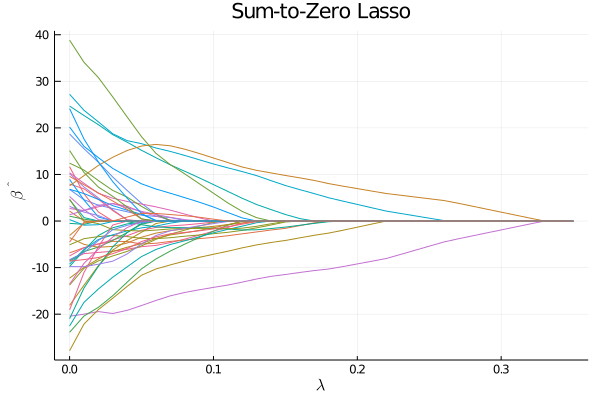

In [37]:
using Plots; gr()
using LaTeXStrings

p = plot(collect(λgrid), β̂path, legend=:none)
xlabel!(p, L"\lambda")
ylabel!(p, L"\hat \beta")
title!(p, "Sum-to-Zero Lasso")

### Sum-to-zero group lasso

Suppose we want to do variable selection not at the OTU level, but at the Phylum level. OTUs are clustered into various Phyla. We can answer this question using a sum-to-zero contrained group lasso
$$
    \text{minimize} \frac 12 \|\mathbf{y} - \mathbf{X} \beta\|_2^2 + \lambda \sum_j \|\mathbf{\beta}_j\|_2
$$
subject to the constraint $\sum_{j=1}^p \beta_j = 0$, where $\mathbf{\beta}_j$ are regression coefficients corresponding to the $j$-th phylum. This is a second-order cone programming (SOCP) problem readily modeled by Convex.jl.

Let's assume each 10 contiguous OTUs belong to one Phylum.

In [38]:
# Use Mosek solver
using Mosek

# # Use Gurobi solver
# using Gurobi
# solver = GurobiSolver(OutputFlag=0)

# # Use Cplex solver
# using CPLEX
# solver = CplexSolver(CPXPARAM_ScreenOutput=0)

# # Use SCS solver
# using SCS
# solver = SCSSolver(verbose=0)

# solve at a grid of λ
λgrid = 0.1:0.005:0.5
β̂pathgrp = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂classo = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # loss
    obj = 0.5sumsquares(y - X * β̂classo)
    # group lasso penalty term
    for j in 1:(size(X, 2)/10)
        βj = β̂classo[(10(j-1)+1):10j]
        obj = obj + λ * norm(βj)
    end
    problem = minimize(obj)
    # constraint
    problem.constraints += sum(β̂classo) == 0 # constraint
    solve!(problem, () -> Mosek.Optimizer(LOG=0))
    β̂pathgrp[i, :] = β̂classo.value
end

  0.815934 seconds (1.21 M allocations: 210.721 MiB, 5.66% gc time)


We it took Mosek <1 second to solve this seemingly hard optimization problem at **80** different $\lambda$ values.

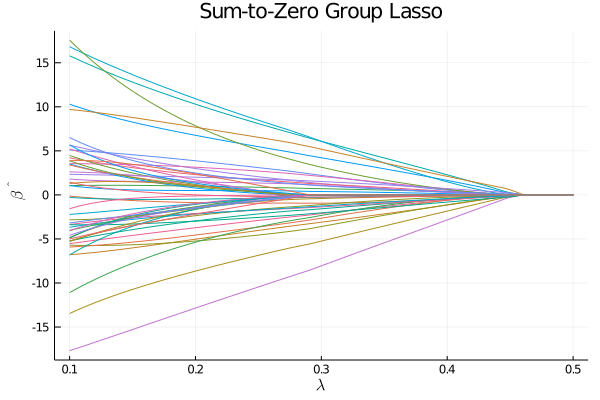

In [39]:
p2 = plot(collect(λgrid), β̂pathgrp, legend=:none)
xlabel!(p2, L"\lambda")
ylabel!(p2, L"\hat \beta")
title!(p2, "Sum-to-Zero Group Lasso")

### Example: matrix completion

Load the $128 \times 128$ Lena picture with missing pixels.

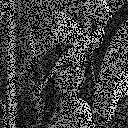

In [40]:
using FileIO

lena = load("lena128missing.png")

In [41]:
# convert to real matrices
Y = Float64.(lena)

128×128 Array{Float64,2}:
 0.0       0.0       0.635294  0.0       …  0.0       0.0       0.627451
 0.627451  0.623529  0.0       0.611765     0.0       0.0       0.388235
 0.611765  0.611765  0.0       0.0          0.403922  0.219608  0.0
 0.0       0.0       0.611765  0.0          0.223529  0.176471  0.192157
 0.611765  0.0       0.615686  0.615686     0.0       0.0       0.0
 0.0       0.0       0.0       0.619608  …  0.0       0.0       0.2
 0.607843  0.0       0.623529  0.0          0.176471  0.192157  0.0
 0.0       0.0       0.623529  0.0          0.0       0.0       0.215686
 0.619608  0.619608  0.0       0.0          0.2       0.0       0.207843
 0.0       0.0       0.635294  0.635294     0.2       0.192157  0.188235
 0.635294  0.0       0.0       0.0       …  0.192157  0.180392  0.0
 0.631373  0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.627451  0.635294  0.666667     0.172549  0.0       0.184314
 ⋮                                       ⋱  ⋮          

We fill out the missin pixels uisng a **matrix completion** technique developed by Candes and Tao
$$
    \text{minimize } \|\mathbf{X}\|_*
$$
$$
    \text{subject to } x_{ij} = y_{ij} \text{ for all observed entries } (i, j).
$$
Here $\|\mathbf{M}\|_* = \sum_i \sigma_i(\mathbf{M})$ is the nuclear norm. In words we seek the matrix with minimal nuclear norm that agrees with the observed entries. This is a semidefinite programming (SDP) problem readily modeled by Convex.jl.

This example takes long because of high dimensionality.

In [42]:
# Use COSMO solver
using COSMO

# Linear indices of obs. entries
obsidx = findall(Y[:] .≠ 0.0)
# Create optimization variables
X = Convex.Variable(size(Y))
# Set up optmization problem
problem = minimize(nuclearnorm(X))
problem.constraints += X[obsidx] == Y[obsidx]
# Solve the problem by calling solve
# @time solve!(problem, () -> Mosek.Optimizer(LOG=1)) # takes about 20min
@time solve!(problem, () -> COSMO.Optimizer()) # fast

------------------------------------------------------------------
          COSMO v0.7.1 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2020
------------------------------------------------------------------

Problem:  x ∈ R^{49153},
          constraints: A ∈ R^{73665x49153} (73793 nnz),
          matrix size to factor: 122818x122818 (270404 nnz)
Sets:     ZeroSet of dim: 40769
          DensePsdConeTriangle of dim: 32896
Settings: ϵ_abs = 1.0e-04, ϵ_rel = 1.0e-04,
          ϵ_prim_inf = 1.0e-06, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1.0e-6, α = 1.6,
          max_iter = 2500,
          scaling iter = 10 (on),
          check termination every 40 iter,
          check infeasibility every 40 iter,
          KKT system solver: CHOLMOD
Setup Time: 78.22ms

Iter:	Objective:	Primal Res:	Dual Res:	Rho:
40	1.4739e+02	1.7996e-02	2.4732e-04	1.0000e-01
80	1.4797e+02	4.6598e-04	4.2189e-05	6.8117e-01
120	1.4797e+0

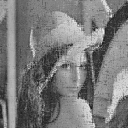

In [43]:
using Images

Gray.(X.value)

## Nonlinear programming (NLP)

We use MLE of Gamma distribution to illustrate some rudiments of nonlinear programming (NLP) in Julia. 

Let $x_1,\ldots,x_m$ be a random sample from the gamma density
$$
f(x) = \Gamma(\alpha)^{-1} \beta^{\alpha} x^{\alpha-1} e^{-\beta x}
$$
on $(0,\infty)$. The loglikelihood function is
$$
    L(\alpha, \beta) = m [- \ln \Gamma(\alpha) + \alpha \ln \beta + (\alpha - 1)\overline{\ln x} - \beta \bar x],
$$
where $\overline{x} = \frac{1}{m} \sum_{i=1}^m x_i$ and 
$\overline{\ln x} = \frac{1}{m} \sum_{i=1}^m \ln x_i$.

In [44]:
using Random, Statistics, SpecialFunctions
Random.seed!(123)

function gamma_logpdf(x::Vector, α::Real, β::Real)
    m = length(x)
    avg = mean(x)
    logavg = sum(log, x) / m
    m * (- log(gamma(α)) + α * log(β) + (α - 1) * logavg - β * avg)
end

x = rand(5)
gamma_logpdf(x, 1.0, 1.0)

-3.0916184386224517

Many optimization algorithms involve taking derivatives of the objective function. The `ForwardDiff.jl` package implements automatic differentiation. For example, to compute the derivative and Hessian of the log-likelihood with data `x` at `α=1.0` and `β=1.0`.

In [45]:
using ForwardDiff

ForwardDiff.gradient(θ -> gamma_logpdf(x, θ...), [1.0; 1.0])

2-element Array{Float64,1}:
 0.07828535245887835
 1.9083815613775483

In [46]:
ForwardDiff.hessian(θ -> gamma_logpdf(x, θ...), [1.0; 1.0])

2×2 Array{Float64,2}:
 -8.22467   5.0
  5.0      -5.0

Generate data:

In [47]:
using Distributions, Random

Random.seed!(123)
(n, p) = (1000, 2)
(α, β) = 5.0 * rand(p)
x = rand(Gamma(α, β), n)
println("True parameter values:")
println("α = ", α, ", β = ", β)

True parameter values:
α = 3.8422383759828493, β = 4.7025750035759355


We use JuMP.jl to define and solve our NLP problem.

In [48]:
using JuMP, Ipopt, NLopt

m = Model(with_optimizer(Ipopt.Optimizer, print_level=3))
# m = Model(with_optimizer(NLopt.Optimizer, algorithm=:LD_MMA))

myf(a, b) = gamma_logpdf(x, a, b)
JuMP.register(m, :myf, 2, myf, autodiff=true)
@variable(m, α >= 1e-8)
@variable(m, β >= 1e-8)
@NLobjective(m, Max, myf(α, β))

print(m)
status = JuMP.optimize!(m)

println("MLE (JuMP):")
println("α = ", α, ", β = ", β)
println("Objective value: ", JuMP.objective_value(m))
println("α = ", JuMP.value(α), ", β = ", 1 / JuMP.value(β))
println("MLE (Distribution package):")
println(fit_mle(Gamma, x))

Max myf(α, β)
Subject to
 α ≥ 1.0e-8
 β ≥ 1.0e-8
Total number of variables............................:        2
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   3.5872527661489071e+03    3.5872527661489071e+03
Dual infeasibility......:   1.9624872101004507e-10    1.9624872101004507e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.00000000000